In [1]:
import cv2
import numpy as np
import os

# 1. Preprocess silhouettes (đã test xong) chạy oke
def preprocess_silhouettes(folder_path):
    silhouettes = []
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths:
        raise ValueError("No valid image files found in the folder.")
    
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠️ Warning: Cannot read image at {path}")
            continue 
        
        _, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
        silhouettes.append(binary)
        
    if not silhouettes:
        raise ValueError("No Valid images were processed. Check file paths")
    
    return np.array(silhouettes)

folder_paths = "data/001/bg-01/108"
binary_imgs = preprocess_silhouettes(folder_paths)



In [35]:
# 2. Compute Gait Energy Image (GEI) (chạy oke)
def compute_gei(silhouettes):
    return np.mean(silhouettes, axis=0)

def show_image(image, title="Image", scale=5):
    h, w = image.shape
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    cv2.imshow(title, resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


gei = compute_gei(binary_imgs)
show_image(gei)

In [36]:
# Save Gait Energy Im
def save_image(image, folder_path, image_name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    save_path = os.path.join(folder_path, image_name)
    cv2.imwrite(save_path, image)
    print(f"✅ Image saved at {save_path}")

# save_image((gei*255).astype(np.uint8), "GEI", f".jpg")

In [ ]:
root_folder = "data"
gei_path = "GEI"
# create a folder to save all the GEI data
if not os.path.exists(gei_path):
    os.makedirs(gei_path)  

# gei_img_process process all the img frames in EACH sample
def gei_img_process(object_data_path):
    # mở mỗi folder trong folder đối tượng chính ra ch cho tới khi đối tượng trong folder chỉ là ảnh
    # 001 > bg-01 > 000 > <ảnh>
    # với mỗi lần mở folder ra cx sẽ tạo ra một folder khác tương ứng với folder đó nhưng thêm chữ GEI vào sau để phân biệt
    
    for folder in os.listdir(object_data_path):
        if not os.path.exists(f"{gei_path}/{folder}"):
            os.makedirs(f"{gei_path}/{folder}")
        for type in os.listdir(f"{object_data_path}/{folder}"):
            binary_imgs = preprocess_silhouettes(f"{object_data_path}/{folder}/{type}")
            gei = compute_gei(binary_imgs)
            save_image((gei*255).astype(np.uint8),f"{gei_path}/{folder}", f"{type}.jpg")

# gei_img_process("data/001")
    

In [73]:
import math

# 3. Generate synthetic GEI templates (oke)
def generate_synthetic_gei(gei, distortion_levels=[0.05, 0.1, 0.15]): # Chatgpt
    h, w = gei.shape
    synthetic_templates = []
    for d in distortion_levels:
        cutoff = int(h * d)
        temp = np.copy(gei)
        temp = temp[0:h - cutoff, :] # cắt 1 phần dưới của ảnh GEI # Simulate lower-body silhouette distortion
        synthetic_templates.append(cv2.resize(temp, (w, h)))
    return synthetic_templates

def synthetic_gei(gei, iter = 5): # Self implement
    syn_temp = []
    x , y = gei.shape
    k, i =  1, 1
    h = max(x,y)
    while(i*k <= h):
        temp = np.copy(gei)
        temp = temp[0:x-i*k,0:y]
        temp = cv2.resize(temp, (x, math.ceil(x*y/(x-i*k))))[0:x,0:y]
        syn_temp.append(temp)
        i += 1
        if(i == iter+1): break
        
    return syn_temp

syn = synthetic_gei(gei)
show_image(gei)

# for i in syn:
#     show_image(i)
#     print(i.shape)

In [77]:
len(syn)

5

In [ ]:
# 4. Implement PCA manually
num_componet = 39

def pca_transform(data, n_components):
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    covariance_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices[:n_components]]
    transformed_data = np.dot(centered_data, eigenvectors)
    return transformed_data, eigenvectors, mean

data, eigen, m = pca_transform(syn[1], num_componet)
print(data.shape)
show_image(data)
print(eigen.shape)
show_image(eigen)
print(m.shape)

(64, 39)
(64, 39)
(64,)


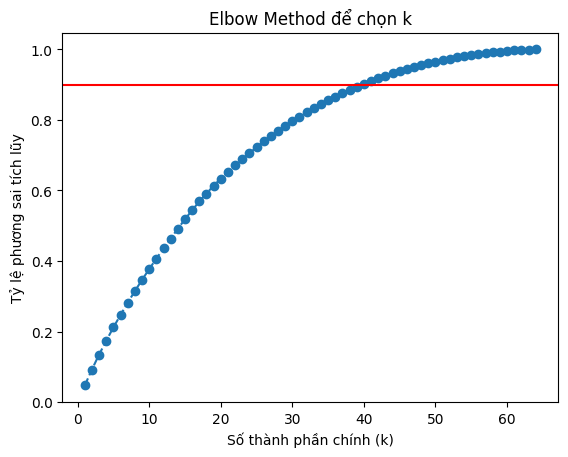

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giả sử có dữ liệu 64 x 64
X = np.random.rand(100, 64)  # 100 mẫu, 64 đặc trưng

# Áp dụng PCA
pca = PCA()
pca.fit(X)

# Tính phương sai tích lũy
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Vẽ biểu đồ khuỷu tay
plt.plot(range(1, 65), explained_variance, marker='o', linestyle='--')
plt.xlabel('Số thành phần chính (k)')
plt.ylabel('Tỷ lệ phương sai tích lũy') 
plt.title('Elbow Method để chọn k')
plt.axhline(y=0.900, color='r', linestyle='-')
plt.show()

In [ ]:
# 5. Implement MDA manually
def mda_transform(data, labels, n_components):
    data = np.array(data) if not isinstance(data, np.ndarray) else data
    labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
    
    unique_classes = np.unique(labels)
    mean_total = np.mean(data, axis=0)
    S_b = np.zeros((data.shape[1], data.shape[1]))
    S_w = np.zeros((data.shape[1], data.shape[1]))
    
    for cls in unique_classes:
        class_data = data[labels == cls]
        mean_class = np.mean(class_data, axis=0)
        S_b += len(class_data) * np.outer(mean_class - mean_total, mean_class - mean_total)
        S_w += np.cov(class_data, rowvar=False) * (len(class_data) - 1)
    
    eigvals, eigvecs = np.linalg.eigh(np.linalg.pinv(S_w).dot(S_b))
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices[:n_components]]
    transformed_data = np.dot(data, eigvecs)
    return transformed_data, eigvecs

show_image(data)

In [ ]:

# 6. Feature extraction using PCA and MDA
def extract_features(train_geis, labels, pca_components=30, mda_components=10):
    pca_features, pca_eigenvectors, pca_mean = pca_transform(train_geis.reshape(len(train_geis), -1), pca_components)
    mda_features, mda_eigenvectors = mda_transform(pca_features, labels, mda_components)
    return mda_features, pca_eigenvectors, mda_eigenvectors, pca_mean

# 7. Implement Euclidean distance manually
def euclidean_distance(X, Y):
    distances = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            distances[i, j] = np.sqrt(np.sum((x - y) ** 2))
    return distances

# 8. Recognize individuals using Euclidean distance
def recognize(probe_features, gallery_features, gallery_labels):
    distances = euclidean_distance(probe_features, gallery_features)
    predictions = [gallery_labels[np.argmin(d)] for d in distances]
    return predictions

# Example Usage:

# image_paths = ["path_to_image1.png", "path_to_image2.png", ...]

silhouettes = preprocess_silhouettes(folder_paths)
gei = compute_gei(silhouettes)
# synthetic_geis = generate_synthetic_gei(gei)
# 
# train_features, pca_eig, mda_eig, pca_mean = extract_features([...], [...])
# probe_features = np.dot(([...] - pca_mean), pca_eig).dot(mda_eig)
# predictions = recognize(probe_features, train_features, [...])